In [1]:
import utils
import pathlib
utils.mount_src()

from data_loader import DataLoader

CONFIG = utils.load_config()
DATA_PATH = CONFIG["images_path"]
MODEL_PATH = pathlib.Path("../models")
EPOCHS = 10
INPUT_SHAPE = (224, 224, 3)

In [2]:
LOSS = {"year": "mse", "lat": "mse", "lon": "mse"}
METRICS = {"year": ["mae"], "lat": ["mae"], "lon": ["mae"]}

In [3]:
from tensorflow import keras

def model_traning_pipeline(model: keras.Model, data_path: str, epochs=10, target_size=(224, 224), callbacks=None):
    data_loader = DataLoader(data_path)
    train_dataset, test_dataset = data_loader.dataset(target_size=target_size)
    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=callbacks
    )
    return {"model": model, "history": history}

In [4]:
def train_models(ms: list[keras.Model], names: list[str]) -> dict[dict]:
    out = {}
    for m, n in zip(ms, names):
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=MODEL_PATH / f"{n}.keras",
                save_best_only=True,
                monitor="val_year_mse",
                mode="min"
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=MODEL_PATH / f"{n}.keras",
                save_best_only=True,
                monitor="val_lat_mse",
                mode="min"
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=MODEL_PATH / f"{n}.keras",
                save_best_only=True,
                monitor="val_lon_mse",
                mode="min"
            )
        ]
        model_training_results = model_traning_pipeline(m, DATA_PATH, epochs=EPOCHS, callbacks=callbacks)
        out[n] = model_training_results
    return out

In [5]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers
import tensorflow as tf

def create_efficient_net() -> keras.Model:
    base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)

    output_year = tf.keras.layers.Dense(1, name="year", activation="sigmoid")(x)
    output_lat = tf.keras.layers.Dense(1, name="lat", activation="sigmoid")(x)
    output_lon = tf.keras.layers.Dense(1, name="lon", activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs={"year": output_year, "lat": output_lat, "lon": output_lon})

efficient_net = create_efficient_net()
efficient_net.compile(
    optimizer="adam",
    loss=LOSS,
    metrics=METRICS
)
efficient_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ input_layer_1[0]… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    196,736 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lat (Dense)         │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lon (Dense)         │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year (Dense)        │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,980,658 (41.89 MB)

 Trainable params: 197,123 (770.01 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [6]:
from tensorflow.keras.applications import ResNet50

def create_res_net():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)

    output_year = tf.keras.layers.Dense(1, name="year", activation="sigmoid")(x)
    output_lat = tf.keras.layers.Dense(1, name="lat", activation="sigmoid")(x)
    output_lon = tf.keras.layers.Dense(1, name="lon", activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs={"year": output_year, "lat": output_lat, "lon": output_lon})

res_net = create_res_net()
res_net.compile(
    optimizer="adam",
    loss=LOSS,
    metrics=METRICS
)
res_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lat (Dense)         │ (None, 1)         │        129 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lon (Dense)         │ (None, 1)         │        129 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year (Dense)        │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
from tensorflow.keras.applications import Xception

def create_xception():
    base_model = Xception(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)

    output_year = tf.keras.layers.Dense(1, name="year", activation="sigmoid")(x)
    output_lat = tf.keras.layers.Dense(1, name="lat", activation="sigmoid")(x)
    output_lon = tf.keras.layers.Dense(1, name="lon", activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs={"year": output_year, "lat": output_lat, "lon": output_lon})

xception = create_xception()
xception.compile(
    optimizer="adam",
    loss=LOSS,
    metrics=METRICS
)
    

In [8]:
def get_callbacks(name: str):
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH / f"{name}.keras",
            save_best_only=True,
            monitor="val_year_mse",
            mode="min"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH / f"{name}.keras",
            save_best_only=True,
            monitor="val_lat_mse",
            mode="min"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH / f"{name}.keras",
            save_best_only=True,
            monitor="val_lon_mse",
            mode="min"
        )
    ]
    return callbacks

In [9]:
name = "efficient_net"

callbacks = get_callbacks(name)

data_loader = DataLoader(DATA_PATH)
train_dataset, test_dataset = data_loader.dataset()

In [10]:
efficient_net_history = efficient_net.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - lat_loss: 0.0164 - lat_mae: 0.0850 - lon_loss: 0.0341 - lon_mae: 0.1362 - loss: 0.0853 - year_loss: 0.0348 - year_mae: 0.1391

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
C:\Users\guisf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_year_mse available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\guisf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_lat_mse available, skipping.
  self._save_model(epoch=epoch, batch=None, 

3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1400s 421ms/step - lat_loss: 0.0164 - lat_mae: 0.0850 - lon_loss: 0.0341 - lon_mae: 0.1362 - loss: 0.0853 - year_loss: 0.0348 - year_mae: 0.1391
Epoch 2/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1445s 427ms/step - lat_loss: 0.0133 - lat_mae: 0.0739 - lon_loss: 0.0293 - lon_mae: 0.1230 - loss: 0.0689 - year_loss: 0.0263 - year_mae: 0.1190
Epoch 3/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1407s 415ms/step - lat_loss: 0.0126 - lat_mae: 0.0720 - lon_loss: 0.0276 - lon_mae: 0.1195 - loss: 0.0640 - year_loss: 0.0239 - year_mae: 0.1135
Epoch 4/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1463s 430ms/step - lat_loss: 0.0119 - lat_mae: 0.0693 - lon_loss: 0.0257 - lon_mae: 0.1155 - loss: 0.0595 - year_loss: 0.0218 - year_mae: 0.1088
Epoch 5/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1450s 429ms/step - lat_loss: 0.0117 - lat_mae: 0.0691 - lon_loss: 0.0246 - lon_mae: 0.1132 - loss: 0.0563 - year_loss: 0.0200 - year_mae: 0.1050
Epoch 6/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1459s 425ms/step - lat_loss: 0.011

In [11]:
name = "res_net"

callbacks = get_callbacks(name)

data_loader = DataLoader(DATA_PATH)
train_dataset, test_dataset = data_loader.dataset()

In [12]:
res_net_history = res_net.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1734s 520ms/step - lat_loss: 0.0175 - lat_mae: 0.0862 - lon_loss: 0.0434 - lon_mae: 0.1511 - loss: 0.0997 - year_loss: 0.0387 - year_mae: 0.1478
Epoch 2/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1742s 523ms/step - lat_loss: 0.0139 - lat_mae: 0.0748 - lon_loss: 0.0317 - lon_mae: 0.1298 - loss: 0.0747 - year_loss: 0.0291 - year_mae: 0.1256
Epoch 3/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1728s 521ms/step - lat_loss: 0.0136 - lat_mae: 0.0738 - lon_loss: 0.0304 - lon_mae: 0.1259 - loss: 0.0711 - year_loss: 0.0271 - year_mae: 0.1201
Epoch 4/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1733s 514ms/step - lat_loss: 0.0131 - lat_mae: 0.0720 - lon_loss: 0.0295 - lon_mae: 0.1233 - loss: 0.0685 - year_loss: 0.0259 - year_mae: 0.1174
Epoch 5/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1735s 522ms/step - lat_loss: 0.0129 - lat_mae: 0.0718 - lon_loss: 0.0289 - lon_mae: 0.1211 - loss: 0.0667 - year_loss: 0.0249 - year_mae: 0.1149
Epoch 6/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1710s 513ms/step - lat_

In [13]:
name = "xception"

callbacks = get_callbacks(name)

data_loader = DataLoader(DATA_PATH)
train_dataset, test_dataset = data_loader.dataset()

In [14]:
xception_history = xception.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1959s 595ms/step - lat_loss: 0.1003 - lat_mae: 0.2884 - lon_loss: 0.2491 - lon_mae: 0.4613 - loss: 0.6668 - year_loss: 0.3174 - year_mae: 0.4831
Epoch 2/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1973s 600ms/step - lat_loss: 0.0983 - lat_mae: 0.2866 - lon_loss: 0.2501 - lon_mae: 0.4630 - loss: 0.6655 - year_loss: 0.3171 - year_mae: 0.4820
Epoch 3/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1995s 602ms/step - lat_loss: 0.0990 - lat_mae: 0.2872 - lon_loss: 0.2505 - lon_mae: 0.4632 - loss: 0.6664 - year_loss: 0.3169 - year_mae: 0.4821
Epoch 4/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1941s 590ms/step - lat_loss: 0.0980 - lat_mae: 0.2862 - lon_loss: 0.2499 - lon_mae: 0.4630 - loss: 0.6622 - year_loss: 0.3143 - year_mae: 0.4798
Epoch 5/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1997s 600ms/step - lat_loss: 0.0978 - lat_mae: 0.2859 - lon_loss: 0.2499 - lon_mae: 0.4629 - loss: 0.6654 - year_loss: 0.3177 - year_mae: 0.4825
Epoch 6/10
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 1965s 598ms/step - lat_

In [15]:
efficient_net.save(MODEL_PATH / "efficient_net.keras")
res_net.save(MODEL_PATH / "res_net.keras")
xception.save(MODEL_PATH / "xception.keras")

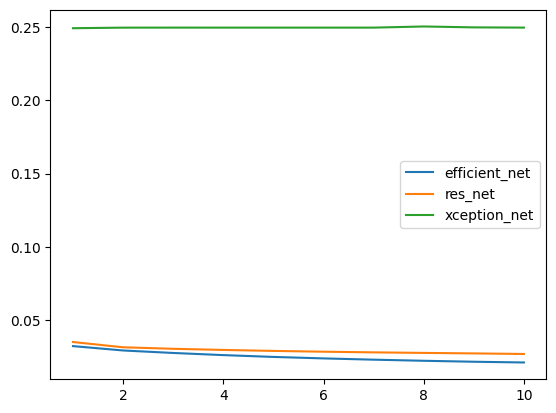

In [26]:
import matplotlib.pyplot as plt

mses = ["year_loss", "lat_loss", "lon_loss"]
names = ["efficient_net", "res_net", "xception"]
histories = [efficient_net_history, res_net_history, xception_history]

epochs = [n for n in range(1, EPOCHS + 1)]

loss = "lon_loss"

loss

plt.plot(epochs, efficient_net_history.history[loss], label="efficient_net")
plt.plot(epochs, res_net_history.history[loss], label="res_net")
plt.plot(epochs, xception_history.history[loss], label="xception_net")
plt.legend()
plt.show()

In [23]:
import polars as pl

HISTORY_DIR = pathlib.Path("../histories")

df = pl.DataFrame(efficient_net_history.history)
df.write_csv(HISTORY_DIR / "efficient_net.csv")

df = pl.DataFrame(res_net_history.history)
df.write_csv(HISTORY_DIR / "res_net.csv")

df = pl.DataFrame(xception_history.history)
df.write_csv(HISTORY_DIR / "xception.csv")